# You are given data (redshift, distance modulus, error in distance modulus) for a set of 42 galaxies using Cepheid variables and other means. These galaxies also have supernovae type Ia observed in them and hence these are used for calibrating supernovae for distance measurements to higher redshifts. Calculate the best fit using least squares and estimate the value of the Hubble’s constant using this data.

<style>
/* Jupyter/MathJax v2 */
.MathJax_Display { font-size: 150% !important; }
/* VS Code & Jupyter with MathJax v3 (CommonHTML) */
mjx-container[jax="CHTML"][display="true"] { font-size: 150% !important; }
</style>


In [1]:
import pandas as pd            # data tables / CSV I/O
import numpy as np             # numerical arrays and math
import matplotlib.pyplot as plt # plotting (matplotlib, as required)


# Loading the data set

In [2]:
path = "galaxies-z-distancemodulus.csv"  # your uploaded file
df = pd.read_csv(path, encoding="latin-1")         # read CSV; latin-1 handled a non-UTF8 char
# Make headers predictable: lowercase, spaces -> underscores
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]


# lets take out all the data


In [3]:
# From your header names, pick the three fields we need:
#   z                    -> 'redshift_(z)'
#   distance modulus     -> 'distance_modulus'
#   error in distance mod-> 'error_in_distance_modulus'
z = df["redshift_(z)"].astype(float).to_numpy()
mu = df["distance_modulus"].astype(float).to_numpy()
sigma_mu = df["error_in_distance_modulus"].astype(float).to_numpy()

# Speed of light in km/s
c_kms = 299792.458


# How to solve it

For small redshift,

$$
d_L \approx \frac{c\,z}{H_0},
$$

where \(c\) is in km s\(^{-1}\), \(H_0\) in km s\(^{-1}\) Mpc\(^{-1}\), and \(d_L\) in Mpc.

Distance modulus:

$$
\mu \equiv m-M
= 5\log_{10}\!\left(\frac{d_L}{10\,\text{pc}}\right)
= 5\log_{10}\!\big(d_L\,[\text{pc}]\big)-5.
$$

Converting \(d_L\) to Mpc gives:

$$
\mu = 5\log_{10}\!\left(\frac{c\,z}{H_0}\right) + 25.
$$

Linearizing in a single unknown:

$$
\mu_i = 5\log_{10}(c\,z_i) - 5\log_{10} H_0 + 25 \equiv A_i + b,
$$

with

$$
A_i = 5\log_{10}(c\,z_i) + 25,
\qquad
b \equiv -5\log_{10} H_0 .
$$

Weighted least squares for \(b\) (errors only on \(\mu\)):

$$
\hat b = \frac{\sum_i w_i\,(\mu_i - A_i)}{\sum_i w_i},
\qquad
w_i = \frac{1}{\sigma_{\mu,i}^2}.
$$

Uncertainty:

$$
\sigma_b^2 = \frac{1}{\sum_i w_i}.
$$

Back to \(H_0\) and error propagation:

$$
H_0 = 10^{-\hat b/5},
\qquad
\sigma_{H_0} = \frac{\ln 10}{5}\, H_0\, \sigma_b .
$$

Goodness of fit:

$$
\chi^2 = \sum_i \frac{\big[\mu_i - (A_i + \hat b)\big]^2}{\sigma_{\mu,i}^2},
\qquad
\chi_\nu^2 = \frac{\chi^2}{N-1}\quad\text{(one fitted parameter)}.
$$


In [4]:
# Build A_i = 5*log10(c z_i) + 25 (the known part of the model)
A = 5.0 * np.log10(c_kms * z) + 25.0


In [5]:
# Weighted least squares for single parameter b:
# weights are inverse-variance in μ
w = 1.0 / (sigma_mu ** 2)

# estimator for b: weighted mean of (μ - A)
b_hat = np.sum(w * (mu - A)) / np.sum(w)

# uncertainty on b: σ_b^2 = 1 / Σ w
sigma_b = np.sqrt(1.0 / np.sum(w))


In [6]:
# Convert b back to H0 via b = -5 log10(H0)
H0 = 10.0 ** (-b_hat / 5.0)

# Propagate error: σ_H0 = (ln 10 / 5) * H0 * σ_b
dH0 = (np.log(10.0) / 5.0) * H0 * sigma_b


In [14]:
# Model μ values at the best-fit b, then chi-square and reduced chi-square
mu_model = A + b_hat 
chi2 = np.sum(((mu - mu_model) / sigma_mu) ** 2)
ndof = len(mu) - 1              # one free parameter (b)
chi2_red = chi2 / ndof


In [9]:
# Print a compact human-readable summary
print(f"H0 = {H0:.2f} ± {dH0:.2f} km/s/Mpc")
print(f"chi2 = {chi2:.3f},  reduced chi2 = {chi2_red:.3f},  N = {len(mu)}, ndof = {ndof}")


H0 = 62.24 ± 0.31 km/s/Mpc
chi2 = 5385654.530,  reduced chi2 = 131357.428,  N = 42, ndof = 41


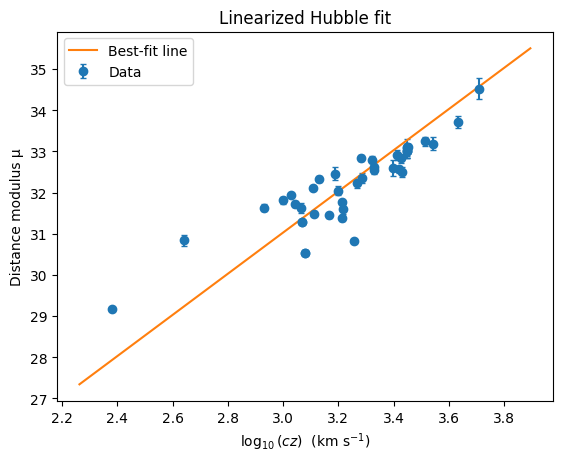

In [12]:
# Plot 1: linearized fit (μ vs log10(c z)) with best-fit straight line μ = 5*log10(cz) + b
x_lin = np.log10(c_kms * z)
plt.figure()
plt.errorbar(x_lin, mu, yerr=sigma_mu, fmt='o', capsize=2, label="Data")
x_grid = np.linspace(x_lin.min()*0.95, x_lin.max()*1.05, 200)
mu_line = 5.0 * x_grid + b_hat + 25
plt.plot(x_grid, mu_line, label="Best-fit line")
plt.xlabel(r"$\log_{10}(c z)$  (km s$^{-1}$)")
plt.ylabel("Distance modulus μ")
plt.title("Linearized Hubble fit")
plt.legend()
plt.show()


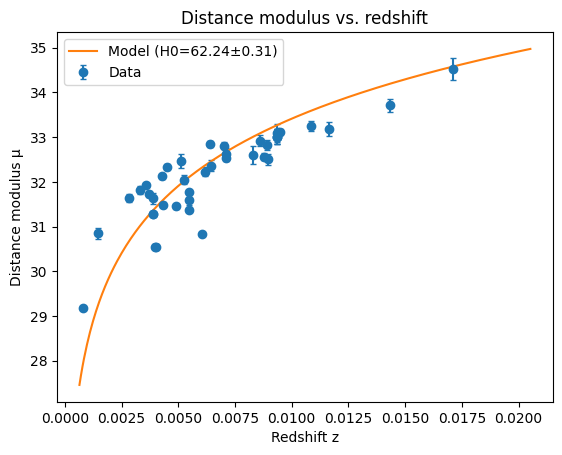

In [13]:
# Plot 2: μ vs z with the best-fit H0 curve (low-z: d_L ≈ c z / H0)
plt.figure()
plt.errorbar(z, mu, yerr=sigma_mu, fmt='o', capsize=2, label="Data")
z_grid = np.linspace(max(1e-6, z.min()*0.8), z.max()*1.2, 300)
mu_model_grid = 5.0 * np.log10((c_kms * z_grid) / H0) + 25.0
plt.plot(z_grid, mu_model_grid, label=f"Model (H0={H0:.2f}±{dH0:.2f})")
plt.xlabel("Redshift z")
plt.ylabel("Distance modulus μ")
plt.title("Distance modulus vs. redshift")
plt.legend()
plt.show()
